In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.enable('json')
from sublimpy import tidy, utils
import pytz

In [46]:
seconds_in_timestep = 60*30
from metpy.constants import density_water

# Open datasets

In [47]:
# Open SOS Measurement Dataset
################################################
start_date = '20221130'
end_date = '20230509'
# open files
tidy_df = pd.read_parquet(f'tidy_df_{start_date}_{end_date}_noplanar_fit_clean.parquet')
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:end_date].reset_index()

tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')


# Open Turbpy Model Ensemble Dataset
################################################
model_df = pd.read_parquet("model_results.parquet")
# add a bunch of columns that are descriptive, from the config column which has multiple bits of info
model_df['z0'] = model_df['config'].apply(
    lambda v: v.split(' ')[-1]
)
model_df['e_sat_curve'] = model_df['config'].apply(
    lambda v: 'metpy' if 'metpy' in v else 'alduchov'
)
model_df['surface_measurement'] = model_df['config'].apply(
    lambda v: v.split(' ')[-3]
)
model_df['scheme'] = model_df['config'].apply(
    lambda v: 'andreas' if 'andreas lengths' in v else 'yang'
)
model_df['most_config'] = model_df['config'].apply(lambda s: ' '.join(s.split(' ')[:-3]))
# remove the scalar roughness length parameterization info 
model_df['most_config'] = model_df['most_config'].str.replace(' andreas lengths', '')
model_df['latent heat flux (mm)'] = -model_df['latent heat flux']*seconds_in_timestep/density_water/2838

model_df = utils.modify_df_timezone(model_df, pytz.UTC, 'US/Mountain')


# Open COARE model results
################################################
coare_model_results = pd.read_parquet("coare_model_results.parquet").reset_index()
coare_model_results['z0'] = coare_model_results.config.str.split(' ').apply(lambda x: x[-2])
coare_model_results['surface_measurement'] = coare_model_results.config.str.split(' ').apply(lambda x: x[0])
coare_model_results['e_sat_curve'] = coare_model_results.config.str.split(' ').apply(lambda x: x[1])
coare_model_results['meas_height'] = coare_model_results.config.str.split(' ').apply(lambda x: int(x[-1].split('m')[0]))

coare_model_results['hlb_mm'] = coare_model_results['hlb_gperm2s']*seconds_in_timestep/density_water

coare_model_results = utils.modify_df_timezone(coare_model_results, pytz.UTC, 'US/Mountain')

# Test corrections (put this somewhere else...)

In [84]:
rho_d = 1.293 #kg/m^3, density of dry air
rho_a = 1.287 #kg/m^3, density of moist air
mu = 1/0.622

def corrected_sensible_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    A, #A
    Mr, #mean_mixing_ratio
):
    Ctc = 0.51*(1 + Q*(mu-1))
    return (
        w_tc_ - Ctc*(T/rho_a)*A*w_h2o_
    ) / (
        1 + Ctc*Q
    )

def corrected_latent_heat_flux(
    w_tc_, #sonic_temperature_flux
    w_h2o_, #h2o_flux
    Q, #specific_humidity
    T, #absolute_temperature
    A, #A
    Mr, #mean_mixing_ratio
):
    Ctc = 0.51*(1 + Q*(mu-1))
    return (1 + mu*Mr)* (
        (A/rho_d)*w_h2o_ + (Mr/T)*(w_tc_)
    ) / (
        1 + Ctc*Q
    )

In [85]:
w_tc__corrected = corrected_sensible_heat_flux(
    tidy_df[tidy_df['variable'] == 'w_tc__3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'w_h2o__3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'specifichumidity_3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'T_3m_c'].value.values,
    0, #A
    tidy_df[tidy_df['variable'] == 'mixingratio_3m_c'].value.values,
)
w_h2o__corrected = corrected_latent_heat_flux(
    tidy_df[tidy_df['variable'] == 'w_tc__3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'w_h2o__3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'specifichumidity_3m_c'].value.values,
    tidy_df[tidy_df['variable'] == 'T_3m_c'].value.values,
    0, #A
    tidy_df[tidy_df['variable'] == 'mixingratio_3m_c'].value.values,
)

In [86]:
compare_src = tidy_df[tidy_df['variable'].isin(['w_tc__3m_c', 'w_h2o__3m_c'])].pivot(
    index='time',
    columns='variable',
    values='value'
)
compare_src['w_tc__3m_c_corrected'] = w_tc__corrected
compare_src['w_h2o__3m_c_corrected'] = w_h2o__corrected

In [87]:
(compare_src['w_tc__3m_c_corrected'] - compare_src['w_tc__3m_c']).mean() / compare_src['w_tc__3m_c'].mean()

-0.0012247558715639713

In [88]:
(compare_src['w_h2o__3m_c_corrected'] - compare_src['w_h2o__3m_c']).mean() / compare_src['w_tc__3m_c'].mean()

0.2680792217420694

<Axes: xlabel='time'>

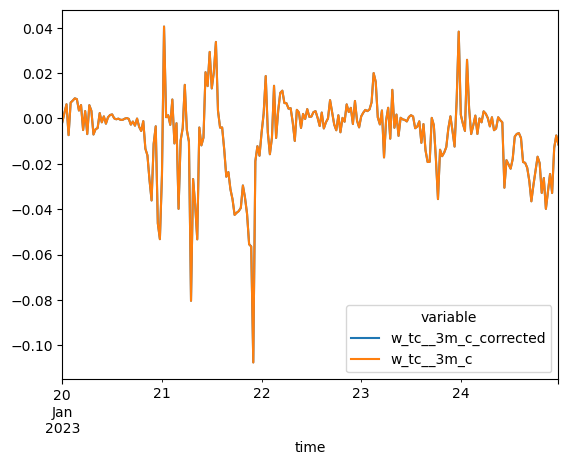

In [90]:
compare_src.loc["20230120": "20230124"][['w_tc__3m_c_corrected', 'w_tc__3m_c']].plot()

<Axes: xlabel='time'>

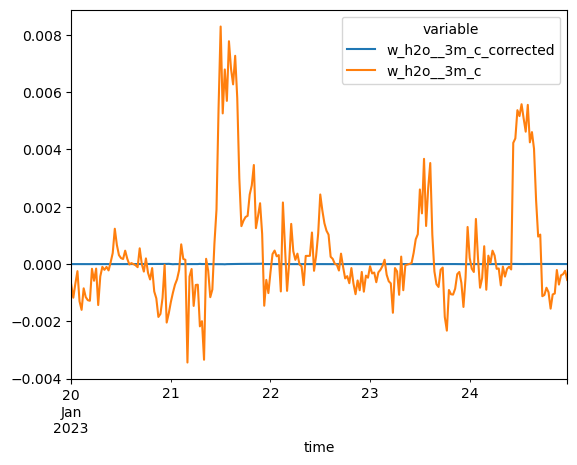

In [89]:
compare_src.loc["20230120": "20230124"][['w_h2o__3m_c_corrected', 'w_h2o__3m_c']].plot()

In [5]:
tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
])].groupby("variable").value.mean()

variable
w_h2o__10m_c    0.002937
w_h2o__15m_c    0.002159
w_h2o__20m_c    0.002323
w_h2o__2m_c     0.002321
w_h2o__3m_c     0.002756
w_h2o__5m_c     0.002824
Name: value, dtype: float64

## Add combined blowing snow flux variable

In [6]:
tidy_df = tidy.tidy_df_add_variable(
    tidy_df,
    (
        tidy_df.query("variable == 'SF_avg_1m_ue'")['value'].values + 
        tidy_df.query("variable == 'SF_avg_2m_ue'")['value'].values
    ), 
    'SF_avg_ue',
    'snow flux',
    1,
    'ue',
)


# Identify lists of timestamps for different categories

In [7]:
bs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value > 0").time
nobs_times = tidy_df.query("variable == 'SF_avg_ue'").query("value == 0").time

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

# Isolate all LH flux measurements (tower c)

In [8]:
lhflux_measurements_df = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
])]
lhflux_measurements_df

,time,variable,value,height,tower,measurement
222,2022-11-29 17:00:00,w_h2o__20m_c,0.008915,20.0,c,w_h2o_
224,2022-11-29 17:00:00,w_h2o__15m_c,0.006543,15.0,c,w_h2o_
226,2022-11-29 17:00:00,w_h2o__10m_c,0.010222,10.0,c,w_h2o_
228,2022-11-29 17:00:00,w_h2o__5m_c,0.003238,5.0,c,w_h2o_
230,2022-11-29 17:00:00,w_h2o__3m_c,0.001886,3.0,c,w_h2o_
...,...,...,...,...,...,...
5270024,2023-05-09 17:30:00,w_h2o__10m_c,0.006808,10.0,c,w_h2o_
5270026,2023-05-09 17:30:00,w_h2o__15m_c,NaN,15.0,c,w_h2o_
5270028,2023-05-09 17:30:00,w_h2o__20m_c,NaN,20.0,c,w_h2o_
5270038,2023-05-09 17:30:00,w_h2o__3m_c,0.003844,3.0,c,w_h2o_


# Calculate frequency of lh flux divergence using 10% and 30% thresholds

We compare measurements at 2 measurement heights at a time (2 and 3, and 3 and 5). This is not comprehensive.

In [9]:
src = lhflux_measurements_df.pivot(index='time', columns='variable', values='value')

## Using 2 and 3 meter measurements and 3 and 5 meter measurements

In [10]:
src['percent diff 2 3'] = (src['w_h2o__3m_c'] - src['w_h2o__2m_c']) / src[['w_h2o__3m_c', 'w_h2o__2m_c']].mean(axis=1)
src['percent diff 3 5'] = (src['w_h2o__5m_c'] - src['w_h2o__3m_c']) / src[['w_h2o__5m_c', 'w_h2o__3m_c']].mean(axis=1)

percent_gt_10_2_3 = len(src[src["percent diff 2 3"] > 0.1])/len(src)
percent_gt_10_3_5 = len(src[src["percent diff 3 5"] > 0.1])/len(src)
percent_gt_30_2_3 = len(src[src["percent diff 2 3"] > 0.3])/len(src)
percent_gt_30_3_5 = len(src[src["percent diff 3 5"] > 0.3])/len(src)

print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")

Using 2 and 3m ECs, LH flux diverges more than 10%, 37.5% of the time
Using 3 and 5m ECs, LH flux diverges more than 10%, 39.4% of the time
Using 2 and 3m ECs, LH flux diverges more than 30%, 23.3% of the time
Using 3 and 5m ECs, LH flux diverges more than 30%, 26.2% of the time


In [11]:
for name, times in [
    ("bs_times", bs_times,),
    ("nobs_times", nobs_times,),
    ("decoupled_times", decoupled_times,),
    ("weaklycoupled_times", weaklycoupled_times,),
    ("coupled_times", coupled_times,),
    ("ri_stable_times", ri_stable_times,),
    ("ri_unstable_times", ri_unstable_times,),
    ("ri_neutral_times", ri_neutral_times,),
    ("tgrad_stable_times", tgrad_stable_times,),
    ("tgrad_unstable_times", tgrad_unstable_times,),
    ("tgrad_neutral_times", tgrad_neutral_times),
]:
    local_src = src.reset_index()
    local_src = local_src[local_src.time.isin(times)]
    percent_gt_10_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.1])/len(local_src)
    percent_gt_10_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.1])/len(local_src)
    percent_gt_30_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.3])/len(local_src)
    percent_gt_30_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.3])/len(local_src)
    print(name)
    print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
    print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")
    print()

bs_times
Using 2 and 3m ECs, LH flux diverges more than 10%, 45.7% of the time
Using 3 and 5m ECs, LH flux diverges more than 10%, 43.4% of the time
Using 2 and 3m ECs, LH flux diverges more than 30%, 22.8% of the time
Using 3 and 5m ECs, LH flux diverges more than 30%, 19.5% of the time

nobs_times
Using 2 and 3m ECs, LH flux diverges more than 10%, 35.3% of the time
Using 3 and 5m ECs, LH flux diverges more than 10%, 38.4% of the time
Using 2 and 3m ECs, LH flux diverges more than 30%, 23.5% of the time
Using 3 and 5m ECs, LH flux diverges more than 30%, 28.2% of the time

decoupled_times
Using 2 and 3m ECs, LH flux diverges more than 10%, 34.2% of the time
Using 3 and 5m ECs, LH flux diverges more than 10%, 41.9% of the time
Using 2 and 3m ECs, LH flux diverges more than 30%, 26.3% of the time
Using 3 and 5m ECs, LH flux diverges more than 30%, 35.2% of the time

weaklycoupled_times
Using 2 and 3m ECs, LH flux diverges more than 10%, 34.9% of the time
Using 3 and 5m ECs, LH flux div

# Plot mean lh flux vertical profiles for different conditions

In [12]:
bs_lhflux_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(bs_times)]
nobs_lhflux_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(nobs_times)]

decoupled_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(decoupled_times)]
weaklycoupled_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(weaklycoupled_times)]
coupled_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(coupled_times)]

ri_stable_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(ri_stable_times)]
ri_unstable_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(ri_unstable_times)]
ri_neutral_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(ri_neutral_times)]

tgrad_stable_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(tgrad_stable_times)]
tgrad_unstable_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(tgrad_unstable_times)]
tgrad_neutral_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(tgrad_neutral_times)]

In [13]:
def lhflux_profile_chart(df, title):
    return (
        alt.Chart(df).transform_aggregate(
            mean = "mean(value)",
            groupby=['height']
        ).transform_calculate(
            low_bound = 'datum.mean - 0.2*datum.mean',
            up_bound = 'datum.mean + 0.2*datum.mean'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q")
        )
        +
        alt.Chart(df).mark_line(color='black').encode(
            alt.X("mean(value):Q").sort('-y').title("w'q' ± 20% (g/m^2/s)"),
            alt.Y("height:Q")
        ).properties(title=f"{title} (n = {len(df.time.unique())})", width=150, height=150)
    )

combo_lhflux_profiles_chart = (
    (
        lhflux_profile_chart(lhflux_measurements_df, "All data") &
        lhflux_profile_chart(bs_lhflux_df, "BS") &
        lhflux_profile_chart(nobs_lhflux_df, "No BS")
    ).resolve_scale(x='shared', y='shared') 
    | 
    (
        lhflux_profile_chart(decoupled_df, "Decoupled") &
        lhflux_profile_chart(weaklycoupled_df, "Weakly coupled") &
        lhflux_profile_chart(coupled_df, "Coupled")
    ).resolve_scale(x='shared', y='shared') 
    | 
    (
        lhflux_profile_chart(ri_stable_df, "Ri Stable") &
        lhflux_profile_chart(ri_neutral_df, "Ri Neutral") &
        lhflux_profile_chart(ri_unstable_df, "Ri Unstable")
    ).resolve_scale(x='shared', y='shared') 
    | 
    (
        lhflux_profile_chart(tgrad_stable_df, "Tgrad stable") &
        lhflux_profile_chart(tgrad_neutral_df, "Tgrad Neutral") &
        lhflux_profile_chart(tgrad_unstable_df, "Tgrad Unstable")
    ).resolve_scale(x='shared', y='shared') 
).resolve_scale(x='shared', y='shared')

combo_lhflux_profiles_chart.save("combo_lhflux_profiles_chart.png", ppi=200)
combo_lhflux_profiles_chart

alt.HConcatChart(...)

In [14]:
bs_and_coupled_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(
    set(bs_times).intersection(set(coupled_times)) 
)]
nobs_and_coupled_df = lhflux_measurements_df[lhflux_measurements_df.time.isin(
    set(nobs_times).intersection(set(coupled_times)) 
)]

(
    lhflux_profile_chart(bs_and_coupled_df, "Coupled, with BS") |\
    lhflux_profile_chart(nobs_and_coupled_df, "Coupled, no BS") 
).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

# Examine how divergence varies with instrument distance from snow surface

In [43]:
div_variation = tidy_df[tidy_df.variable.isin([
    # 'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'SnowDepth_c',
])].pivot(index='time', columns='variable', values='value').reset_index()
div_variation['height_adj'] = 2 - div_variation['SnowDepth_c']

div_variation['lhflux_div_2_3'] = (div_variation['w_h2o__3m_c'] - div_variation['w_h2o__2m_c']) / 1
div_variation['lhflux_div_3_5'] = (div_variation['w_h2o__5m_c'] - div_variation['w_h2o__3m_c']) / 2
div_variation['lhflux_div_5_10'] = (div_variation['w_h2o__10m_c'] - div_variation['w_h2o__5m_c']) / 5

In [44]:
chart_2_3 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_2_3 <= 1
).transform_filter(
    alt.datum.lhflux_div_2_3 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_2_3:Q").title("d(w'q')/dz, 2-3m")
) + alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_3_5 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_3_5 <= 1
).transform_filter(
    alt.datum.lhflux_div_3_5 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_3_5:Q").title("d(w'q')/dz, 3-5m")
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_5_10 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_5_10 <= 1
).transform_filter(
    alt.datum.lhflux_div_5_10 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_5_10:Q").title(("d(w'q')/dz, 5-10m"))
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

(chart_2_3 | chart_3_5 | chart_5_10).display(renderer='svg')

alt.HConcatChart(...)

# December wind event case study

## Plot Vertical Profiles

Sensible heat

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_tc__1m_c', 'w_tc__2m_c', 'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c',
    'w_tc__1m_ue',  'w_tc__1m_uw',  'w_tc__1m_d',
    'w_tc__3m_ue',  'w_tc__3m_uw',  'w_tc__3m_d',
    'w_tc__10m_ue', 'w_tc__10m_uw', 'w_tc__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_tc_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("w'tc'"), #.scale(domain=[-0.25,0], clamp=True),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
    ).properties(width=75,height=75)

Potential temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface potential temperature',
    'potential temperature'
])].query("tower == 'c'")
theta_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

Temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface temperature',
    'temperature'
])].query("tower == 'c'")
T_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)
T_prof_timeseries_chart

lh flux 

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c', 'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__1m_ue',  'w_h2o__1m_uw',  'w_h2o__1m_d',
    'w_h2o__3m_ue',  'w_h2o__3m_uw',  'w_h2o__3m_d',
    'w_h2o__10m_ue', 'w_h2o__10m_uw', 'w_h2o__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_q_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("w'q'"),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=75,height=75)

RH

In [ ]:
src = tidy_df[tidy_df.measurement=='RH'].query("height != 6").query("height != 12")
rh_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_circle().encode(
        alt.X("mean(value):Q").sort('-y').title("RH (%)").scale(domain=[55,75]),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

blowing snow time series

In [ ]:
# src = tidy_df[tidy_df.variable == 'SF_avg_ue']
src = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])]
# src = src[src.time.isin(bs_times)]
bs_flux_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_circle(point=True, size=75).encode(
        alt.X("time:T"),
        alt.Y("value:Q").scale(type='log').title("Blowing snow flux (g/m^2/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 

src = tidy_df[tidy_df.variable.isin(['spd_3m_c', 'spd_5m_c', 'spd_20m_c'])]
windspd_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'u*_5m_c', 'u*_20m_c'])]
ufric_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Friction velocity (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


In [ ]:
(
    ufric_timeseries_chart & windspd_timeseries_chart & bs_flux_timeseries_chart & 
    (w_q_prof_timeseries_chart & rh_prof_timeseries_chart & w_tc_prof_timeseries_chart & theta_prof_timeseries_chart)
).resolve_scale(color='independent')

Look at time series of Snow surface temperature, and other related variables, to see what is going on with surface temperatures during the blowing snow event

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "2022-12-21 12": "2022-12-22 23"
].reset_index()
# Create DF with renamed Tsnow variables to clarify that they are air sensors at this time because
# snowdepth during this time period is 30-40cm, so the in-snow T sensors are ~10, 20cm above snow
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_4m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_5m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_6m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_7m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')   

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_0_4m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    "Tsnow_0_4m_d",
    'T_00cm_c'
)

bs_case_study =(alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c'],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20221221": "20221223"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "20230210": "20230212"
].reset_index()
# rename the Tsnow variables so clarify that the snowdepth during this time period is 88cm, 
# so the in-snow T sensors are actually ~10, 20, cm above the snow surface
# When we looked at T sensors at 80cm and 90cm, they were clearly under snow (signal attenuated)
# So we think its a decent estimate that the snow by the instrument is actually ~1m deep
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_1_0m_d',
    'Tsnow_1_1m_d',
    'Tsnow_1_2m_d',
    'Tsnow_1_3m_d',
    # 'Tsnow_1_4m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_0m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_1m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_2m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_1_3m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_1_0m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    'Tsnow_1_0m_d',
    'T_00cm_c'
)

clear_case_study = (alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_2m_c', 'T_00cm_c', 'T_10cm_c', 'T_20cm_c','T_30cm_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c','T_30cm_c', 'T_2m_c', ],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
    # alt.StrokeDash("measurement:N"),
    detail='variable'
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    # alt.StrokeDash("measurement:N"),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20230210": "20230212"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q")
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement:N").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
(bs_case_study | clear_case_study)